<a href="https://colab.research.google.com/github/Youssef-Keshk/Assignment2-LogisticRegression-SoftmaxRegression-NeuralNets/blob/main/notebooks/partA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST Linear Classification - Part A Complete Implementation
Includes both Logistic Regression (Binary) and Softmax Regression (Multi-class)

##1. Importing Libararies


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

## SECTION 1: DATA PREPARATION (A1)




In [ ]:
transform_flatten = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten 28×28 to 784
])

train_dataset_f = datasets.MNIST(root='./data', train=True,
                                 transform=transform_flatten, download=True)
test_dataset_f = datasets.MNIST(root='./data', train=False,
                                transform=transform_flatten, download=True)

##3. split: 60% train, 20% val, 20% test

In [ ]:
idx = list(range(len(train_dataset_f)))
train_idx, temp_idx = train_test_split(idx, test_size=0.40,
                                       stratify=train_dataset_f.targets,
                                       random_state=42)
val_idx, extra_test_idx = train_test_split(temp_idx, test_size=0.50,
                                           stratify=train_dataset_f.targets[temp_idx],
                                           random_state=42)

train_dataset = Subset(train_dataset_f, train_idx)
val_dataset = Subset(train_dataset_f, val_idx)
extra_test_dataset = Subset(train_dataset_f, extra_test_idx)
test_dataset = ConcatDataset([test_dataset_f, extra_test_dataset])

print(f"\nFinal Split:")
print(f"  Training: {len(train_dataset)} ({len(train_dataset)/len(train_dataset_f)*100:.1f}%)")
print(f"  Validation: {len(val_dataset)} ({len(val_dataset)/len(train_dataset_f)*100:.1f}%)")
print(f"  Test: {len(extra_test_idx)} ({len(extra_test_idx)/len(train_dataset_f)*100:.1f}%)")
print(f"  Test: {len(test_dataset)} samples")


Final Split:
  Training: 36000 (60.0%)
  Validation: 12000 (20.0%)
  Test: 12000 (20.0%)
  Test: 22000 samples


##4. SECTION 2: LOGISTIC REGRESSION - BINARY CLASSIFICATION (A2)


4.1 Filter only 0,1

In [ ]:
def filter_binary(dataset, class_a=0, class_b=1):
    binary_data = []
    for x, y in dataset:
        if y in [class_a, class_b]:
            binary_data.append((x, torch.tensor(float(y == class_b))))
    return binary_data


###4.2 create binary datasets

In [ ]:
train_binary = filter_binary(train_dataset, 0, 1)
val_binary = filter_binary(val_dataset, 0, 1)
test_binary = filter_binary(test_dataset, 0, 1)

train_loader_bin = DataLoader(train_binary, batch_size=64, shuffle=True)
val_loader_bin = DataLoader(val_binary, batch_size=64, shuffle=False)
test_loader_bin = DataLoader(test_binary, batch_size=64, shuffle=False)

print(f"Binary dataset sizes:")
print(f"  Train: {len(train_binary)}")
print(f"  Val: {len(val_binary)}")
print(f"  Test: {len(test_binary)}")

input_dim = 784
W_bin = torch.zeros((input_dim, 1), requires_grad=False) * 0.01
b_bin = torch.zeros(1, requires_grad=False)

def sigmoid(z):
    return torch.sigmoid(z)

def predict_binary(X):
    z = X @ W_bin + b_bin
    return sigmoid(z)

def binary_cross_entropy(y_pred, y_true):
    eps = 1e-9
    y_pred = torch.clamp(y_pred, eps, 1 - eps)
    return -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))

def update_weights_binary(X, y_true, y_pred, lr=0.01):
    global W_bin, b_bin
    m = X.shape[0]
    error = y_pred - y_true

    dW = (X.t() @ error) / m
    db = torch.mean(error)

    W_bin -= lr * dW
    b_bin -= lr * db

def accuracy_binary(pred, labels):
    pred_labels = (pred >= 0.5).float()
    return (pred_labels == labels).float().mean().item()


Binary dataset sizes:
  Train: 7599
  Val: 2534
  Test: 4647


###4.3 Training loop for binary classification

In [ ]:
num_epochs = 20
lr = 0.01

train_losses_bin = []
val_losses_bin = []
train_accs_bin = []
val_accs_bin = []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    total_train = 0

    for X_batch, y_batch in train_loader_bin:
        y_batch = y_batch.view(-1, 1)
        preds = predict_binary(X_batch)
        loss = binary_cross_entropy(preds, y_batch)

        update_weights_binary(X_batch, y_batch, preds, lr=lr)

        train_loss += loss.item() * X_batch.size(0)
        train_acc += accuracy_binary(preds, y_batch) * X_batch.size(0)
        total_train += X_batch.size(0)

    train_loss /= total_train
    train_acc /= total_train
    val_loss = 0.0
    val_acc = 0.0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader_bin:
            y_batch = y_batch.view(-1, 1)
            preds = predict_binary(X_batch)
            loss = binary_cross_entropy(preds, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            val_acc += accuracy_binary(preds, y_batch) * X_batch.size(0)
            total_val += X_batch.size(0)

    val_loss /= total_val
    val_acc /= total_val

    train_losses_bin.append(train_loss)
    val_losses_bin.append(val_loss)
    train_accs_bin.append(train_acc)
    val_accs_bin.append(val_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 5/20 | Train Loss: 0.0338, Train Acc: 0.9975 | Val Loss: 0.0349, Val Acc: 0.9953
Epoch 10/20 | Train Loss: 0.0204, Train Acc: 0.9979 | Val Loss: 0.0235, Val Acc: 0.9953
Epoch 15/20 | Train Loss: 0.0157, Train Acc: 0.9979 | Val Loss: 0.0192, Val Acc: 0.9957
Epoch 20/20 | Train Loss: 0.0132, Train Acc: 0.9979 | Val Loss: 0.0168, Val Acc: 0.9964



##3. SOFTMAX REGRESSION - MULTI-CLASS CLASSIFICATION (A3)

##3.1 Create multi-class datasets


In [ ]:
def prepare_multiclass(dataset):
    data = []
    for x, y in dataset:
        data.append((x, y))
    return data

train_multi = prepare_multiclass(train_dataset)
val_multi = prepare_multiclass(val_dataset)
test_multi = prepare_multiclass(test_dataset)

train_loader_multi = DataLoader(train_multi, batch_size=64, shuffle=True)
val_loader_multi = DataLoader(val_multi, batch_size=64, shuffle=False)
test_loader_multi = DataLoader(test_multi, batch_size=64, shuffle=False)

print(f"Multi-class dataset sizes:")
print(f"  Train: {len(train_multi)}")
print(f"  Val: {len(val_multi)}")
print(f"  Test: {len(test_multi)}")

Multi-class dataset sizes:
  Train: 36000
  Val: 12000
  Test: 22000


##3.2 Initialize parameters for 10 classes


In [ ]:
num_classes = 10
W_multi = torch.randn((input_dim, num_classes), requires_grad=False) * 0.01
b_multi = torch.zeros(num_classes, requires_grad=False)

def softmax(z):
    z_shifted = z - torch.max(z, dim=1, keepdim=True)[0]
    exp_z = torch.exp(z_shifted)
    return exp_z / torch.sum(exp_z, dim=1, keepdim=True)

def predict_multiclass(X):
    z = X @ W_multi + b_multi
    return softmax(z)

def cross_entropy_loss(y_pred, y_true):
    eps = 1e-9
    y_pred = torch.clamp(y_pred, eps, 1 - eps)

    batch_size = y_true.size(0)
    y_one_hot = torch.zeros(batch_size, num_classes)
    y_one_hot[torch.arange(batch_size), y_true.long()] = 1

    loss = -torch.sum(y_one_hot * torch.log(y_pred)) / batch_size
    return loss

def update_weights_multiclass(X, y_true, y_pred, lr=0.01):
    global W_multi, b_multi
    m = X.shape[0]

    y_one_hot = torch.zeros(m, num_classes)
    y_one_hot[torch.arange(m), y_true.long()] = 1

    error = y_pred - y_one_hot

    dW = (X.t() @ error) / m
    db = torch.mean(error, dim=0)

    W_multi -= lr * dW
    b_multi -= lr * db

def accuracy_multiclass(pred, labels):
    pred_labels = torch.argmax(pred, dim=1)
    return (pred_labels == labels).float().mean().item()

##3.3 Training loop for multi-class classification


In [ ]:
num_epochs = 20
lr = 0.01

train_losses_multi = []
val_losses_multi = []
train_accs_multi = []
val_accs_multi = []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    total_train = 0

    for X_batch, y_batch in train_loader_multi:
        preds = predict_multiclass(X_batch)
        loss = cross_entropy_loss(preds, y_batch)

        update_weights_multiclass(X_batch, y_batch, preds, lr=lr)

        train_loss += loss.item() * X_batch.size(0)
        train_acc += accuracy_multiclass(preds, y_batch) * X_batch.size(0)
        total_train += X_batch.size(0)

    train_loss /= total_train
    train_acc /= total_train

    val_loss = 0.0
    val_acc = 0.0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader_multi:
            preds = predict_multiclass(X_batch)
            loss = cross_entropy_loss(preds, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            val_acc += accuracy_multiclass(preds, y_batch) * X_batch.size(0)
            total_val += X_batch.size(0)

    val_loss /= total_val
    val_acc /= total_val

    train_losses_multi.append(train_loss)
    val_losses_multi.append(val_loss)
    train_accs_multi.append(train_acc)
    val_accs_multi.append(val_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 5/20 | Train Loss: 0.4582, Train Acc: 0.8815 | Val Loss: 0.4587, Val Acc: 0.8831
Epoch 10/20 | Train Loss: 0.3856, Train Acc: 0.8952 | Val Loss: 0.3973, Val Acc: 0.8941
Epoch 15/20 | Train Loss: 0.3559, Train Acc: 0.9012 | Val Loss: 0.3711, Val Acc: 0.8999
Epoch 20/20 | Train Loss: 0.3384, Train Acc: 0.9058 | Val Loss: 0.3562, Val Acc: 0.9043
✓ Multi-class classification training complete!


# SECTION 4: EVALUATION AND VISUALIZATION


In [ ]:
def evaluate_binary(test_loader):
    all_preds = []
    all_labels = []
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_batch = y_batch.view(-1, 1)
            preds = predict_binary(X_batch)
            pred_labels = (preds >= 0.5).float()

            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

            test_correct += (pred_labels == y_batch).sum().item()
            test_total += y_batch.size(0)

    test_accuracy = test_correct / test_total
    return test_accuracy, np.array(all_preds), np.array(all_labels)

def evaluate_multiclass(test_loader):
    all_preds = []
    all_labels = []
    test_correct = 0
    test_total = 0
    per_class_correct = torch.zeros(num_classes)
    per_class_total = torch.zeros(num_classes)

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = predict_multiclass(X_batch)
            pred_labels = torch.argmax(preds, dim=1)

            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

            test_correct += (pred_labels == y_batch).sum().item()
            test_total += y_batch.size(0)

            for i in range(num_classes):
                mask = y_batch == i
                per_class_correct[i] += (pred_labels[mask] == y_batch[mask]).sum().item()
                per_class_total[i] += mask.sum().item()

    test_accuracy = test_correct / test_total
    per_class_accuracy = per_class_correct / per_class_total
    return test_accuracy, np.array(all_preds), np.array(all_labels), per_class_accuracy

test_acc_bin, test_preds_bin, test_labels_bin = evaluate_binary(test_loader_bin)
test_acc_multi, test_preds_multi, test_labels_multi, per_class_acc = evaluate_multiclass(test_loader_multi)

print(f"\n BINARY CLASSIFICATION (0 vs 1)")
print(f"  Test Accuracy: {test_acc_bin:.4f} ({test_acc_bin*100:.2f}%)")

print(f"\n MULTI-CLASS CLASSIFICATION (All 10 digits)")
print(f"  Test Accuracy: {test_acc_multi:.4f} ({test_acc_multi*100:.2f}%)")
print(f"\n  Per-Class Accuracy:")
for i in range(num_classes):
    print(f"    Digit {i}: {per_class_acc[i]:.4f} ({per_class_acc[i]*100:.2f}%)")


 BINARY CLASSIFICATION (0 vs 1)
  Test Accuracy: 0.9985 (99.85%)

 MULTI-CLASS CLASSIFICATION (All 10 digits)
  Test Accuracy: 0.9061 (90.61%)

  Per-Class Accuracy:
    Digit 0: 0.9713 (97.13%)
    Digit 1: 0.9702 (97.02%)
    Digit 2: 0.8746 (87.46%)
    Digit 3: 0.8860 (88.60%)
    Digit 4: 0.9107 (91.07%)
    Digit 5: 0.8391 (83.91%)
    Digit 6: 0.9374 (93.74%)
    Digit 7: 0.9062 (90.62%)
    Digit 8: 0.8605 (86.05%)
    Digit 9: 0.8913 (89.13%)


# VISUALIZATION

## 1. Binary Classification - Loss and Accuracy Curves


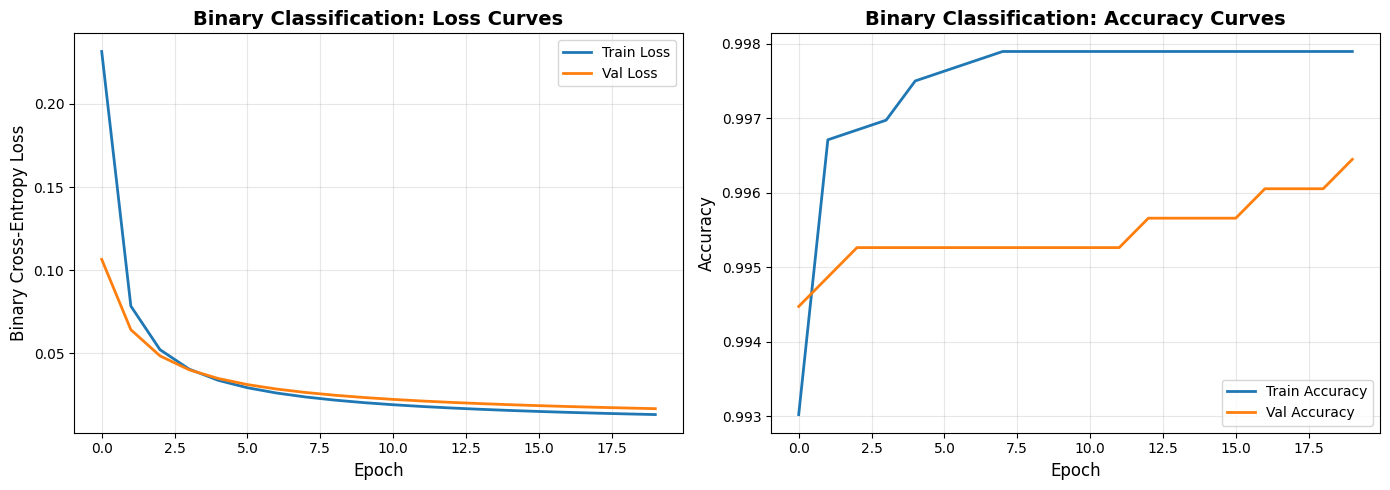

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses_bin, label='Train Loss', linewidth=2)
axes[0].plot(val_losses_bin, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Binary Cross-Entropy Loss', fontsize=12)
axes[0].set_title('Binary Classification: Loss Curves', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs_bin, label='Train Accuracy', linewidth=2)
axes[1].plot(val_accs_bin, label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Binary Classification: Accuracy Curves', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2. Multi-class Classification - Loss and Accuracy Curves


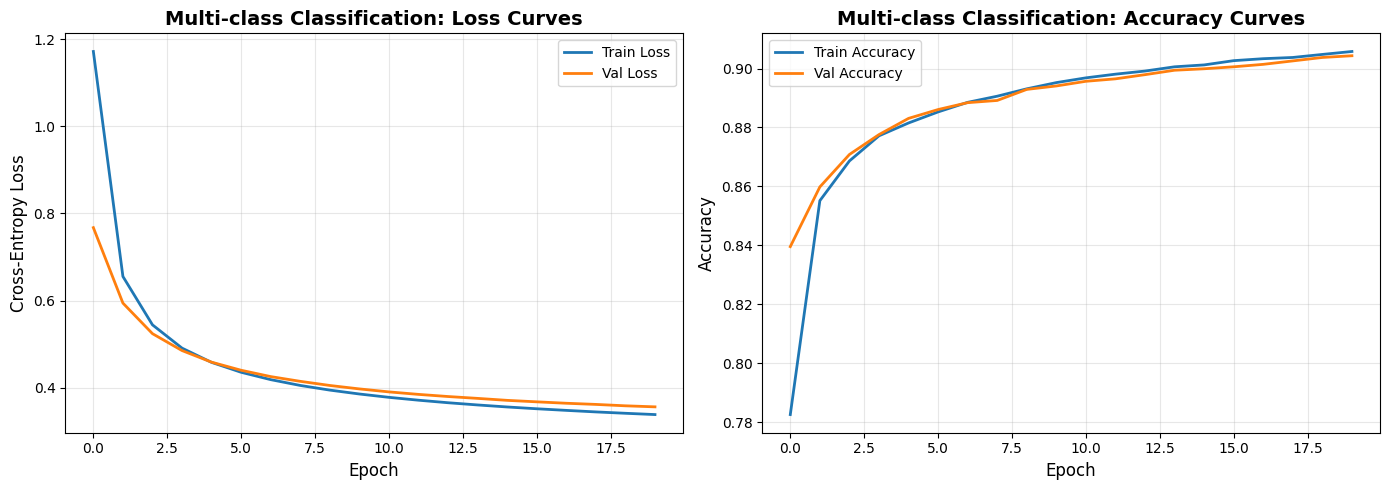

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses_multi, label='Train Loss', linewidth=2)
axes[0].plot(val_losses_multi, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Cross-Entropy Loss', fontsize=12)
axes[0].set_title('Multi-class Classification: Loss Curves', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs_multi, label='Train Accuracy', linewidth=2)
axes[1].plot(val_accs_multi, label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Multi-class Classification: Accuracy Curves', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Confusion Matrices
    Binary confusion matrix
    Multi-class confusion matrix

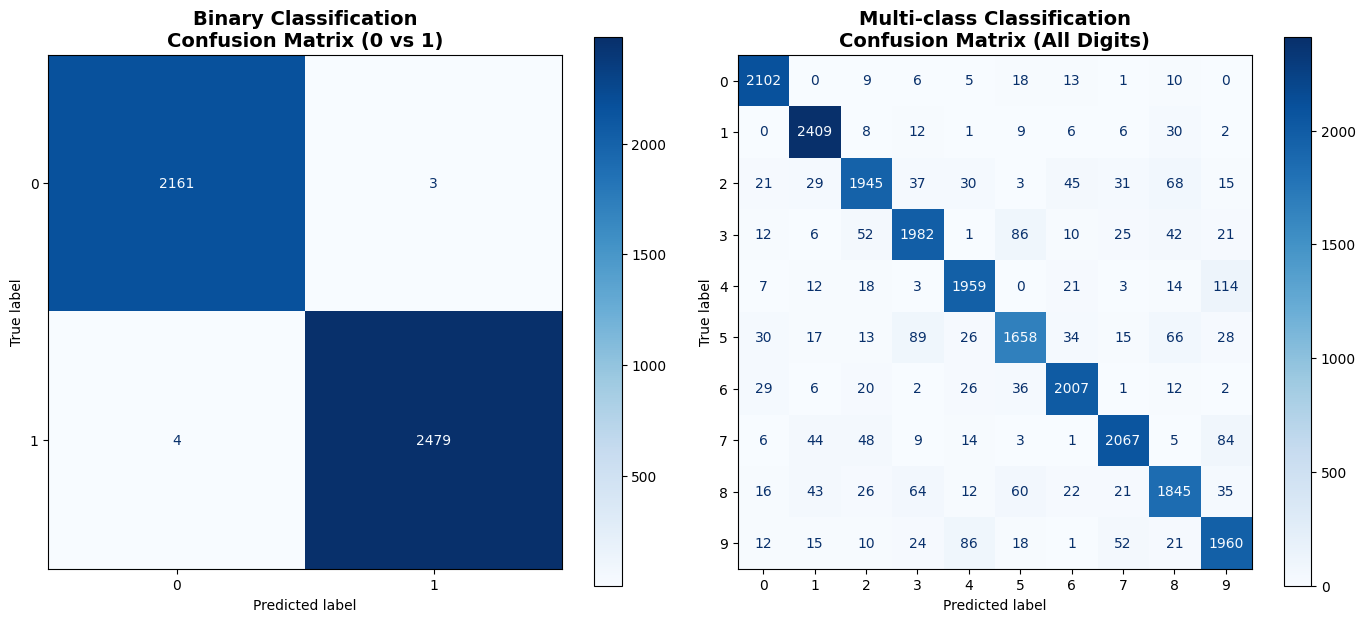

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cm_bin = confusion_matrix(test_labels_bin, test_preds_bin)
disp_bin = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=['0', '1'])
disp_bin.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Binary Classification\nConfusion Matrix (0 vs 1)', fontsize=14, fontweight='bold')
cm_multi = confusion_matrix(test_labels_multi, test_preds_multi)
disp_multi = ConfusionMatrixDisplay(confusion_matrix=cm_multi,
                                   display_labels=[str(i) for i in range(10)])
disp_multi.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Multi-class Classification\nConfusion Matrix (All Digits)',
                  fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Per-class accuracy bar chart

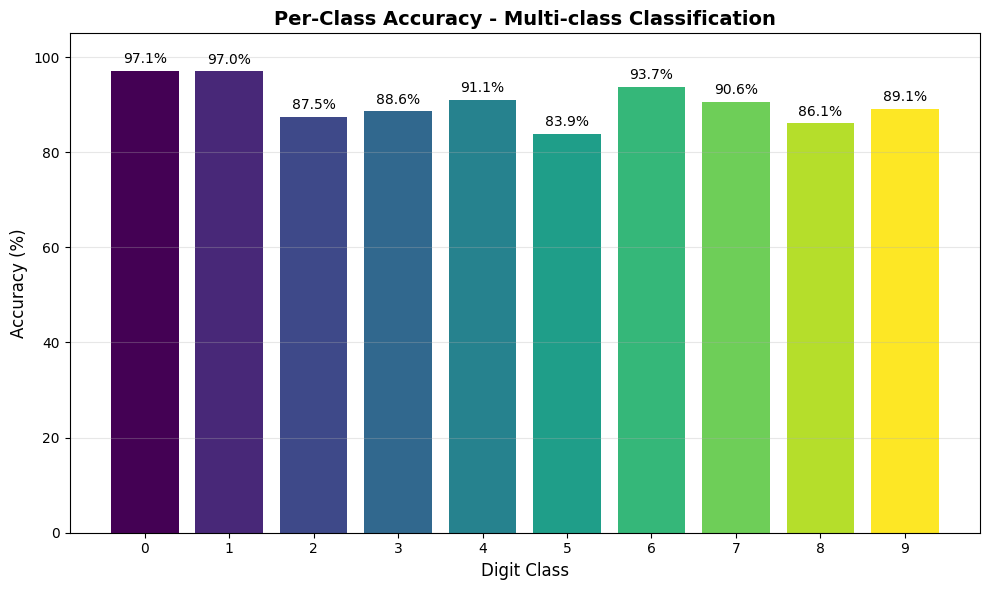

In [ ]:
plt.figure(figsize=(10, 6))
bars = plt.bar(range(num_classes), per_class_acc.numpy() * 100,
               color=plt.cm.viridis(np.linspace(0, 1, num_classes)))
plt.xlabel('Digit Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Per-Class Accuracy - Multi-class Classification', fontsize=14, fontweight='bold')
plt.xticks(range(num_classes))
plt.ylim([0, 105])
plt.grid(True, axis='y', alpha=0.3)

for i, (bar, acc) in enumerate(zip(bars, per_class_acc)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc*100:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# FINAL SUMMARY


In [ ]:
print("\n BINARY CLASSIFICATION (Logistic Regression):")
print(f"  Final Train Accuracy: {train_accs_bin[-1]:.4f}")
print(f"  Final Val Accuracy: {val_accs_bin[-1]:.4f}")
print(f"  Final Test Accuracy: {test_acc_bin:.4f}")
print(f"  Final Train Loss: {train_losses_bin[-1]:.4f}")
print(f"  Final Val Loss: {val_losses_bin[-1]:.4f}")

tn, fp, fn, tp = cm_bin.ravel()
precision_bin = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_bin = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_bin = 2 * (precision_bin * recall_bin) / (precision_bin + recall_bin) if (precision_bin + recall_bin) > 0 else 0

print(f"\n  Detailed Metrics:")
print(f"    Precision: {precision_bin:.4f}")
print(f"    Recall: {recall_bin:.4f}")
print(f"    F1-Score: {f1_bin:.4f}")

print("\n MULTI-CLASS CLASSIFICATION (Softmax Regression):")
print(f"  Final Train Accuracy: {train_accs_multi[-1]:.4f}")
print(f"  Final Val Accuracy: {val_accs_multi[-1]:.4f}")
print(f"  Final Test Accuracy: {test_acc_multi:.4f}")
print(f"  Final Train Loss: {train_losses_multi[-1]:.4f}")
print(f"  Final Val Loss: {val_losses_multi[-1]:.4f}")

print(f"\n  Best Performing Digit: {torch.argmax(per_class_acc).item()} "
      f"({per_class_acc[torch.argmax(per_class_acc)]*100:.2f}%)")
print(f"  Worst Performing Digit: {torch.argmin(per_class_acc).item()} "
      f"({per_class_acc[torch.argmin(per_class_acc)]*100:.2f}%)")
from sklearn.metrics import precision_recall_fscore_support

precision_multi, recall_multi, f1_multi, _ = precision_recall_fscore_support(
    test_labels_multi, test_preds_multi, average='weighted'
)

print("\n MULTI-CLASS CLASSIFICATION (Softmax Regression) - Additional Metrics:")
print(f"  Precision (weighted): {precision_multi:.4f}")
print(f"  Recall (weighted): {recall_multi:.4f}")
print(f"  F1-Score (weighted): {f1_multi:.4f}")


 BINARY CLASSIFICATION (Logistic Regression):
  Final Train Accuracy: 0.9979
  Final Val Accuracy: 0.9964
  Final Test Accuracy: 0.9985
  Final Train Loss: 0.0132
  Final Val Loss: 0.0168

  Detailed Metrics:
    Precision: 0.9988
    Recall: 0.9984
    F1-Score: 0.9986

 MULTI-CLASS CLASSIFICATION (Softmax Regression):
  Final Train Accuracy: 0.9058
  Final Val Accuracy: 0.9043
  Final Test Accuracy: 0.9061
  Final Train Loss: 0.3384
  Final Val Loss: 0.3562

  Best Performing Digit: 0 (97.13%)
  Worst Performing Digit: 5 (83.91%)

 MULTI-CLASS CLASSIFICATION (Softmax Regression) - Additional Metrics:
  Precision (weighted): 0.9058
  Recall (weighted): 0.9061
  F1-Score (weighted): 0.9058


# Saving the models

In [ ]:
# Saving the binary model (weights and bias)
torch.save({
    'W_bin': W_bin,
    'b_bin': b_bin,
}, 'binary_logistic_regression_model.pth')

# Saving the multi-class model (weights and bias)
torch.save({
    'W_multi': W_multi,
    'b_multi': b_multi,
}, 'multi_class_softmax_regression_model.pth')

print("Binary and multi-class models saved successfully!")

Binary and multi-class models saved successfully!
